In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import holidays
import streamlit as st
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

In [86]:
ventas_data = r"D:\forecasting_retailer\data\raw\training\ventas.csv"
competencia_data = r"D:\forecasting_retailer\data\raw\training\competencia.csv"

ventas_df = pd.read_csv(ventas_data)
competencia_df = pd.read_csv(competencia_data)

In [87]:
# Convertir la columna 'fecha' a 'datetime' en ambos df#

ventas_df['fecha'] = pd.to_datetime(ventas_df['fecha'])
competencia_df['fecha'] = pd.to_datetime(competencia_df['fecha'])

In [88]:
# Validación de la calidad de los datos "ventas_df" #
print("Tipos de variables")
print(ventas_df.dtypes)
print("\n")

# Nulos por columna #
print("Valores nulos por columna")
print(ventas_df.isnull().sum())
print("\n")

# Duplicados #
duplicados = ventas_df.duplicated().sum()
print(f"Filas duplicadas: {duplicados}\n")

# Estadistica descriptiva #
print ("Estadistica descriptiva")
print(ventas_df.describe(include='all'))
print("\n")

# Resumen Final #
print ("Resumen final")
if ventas_df.isnull().sum().sum() == 0:
    print("No hay valores nulos")
else:
    print("Existen valores nulos")
if duplicados == 0:
    print("No hay filas duplicadas")
else:
    print(f"Hay {duplicados} filas duplicadas")

Tipos de variables
fecha                datetime64[ns]
producto_id                  object
nombre                       object
categoria                    object
subcategoria                 object
precio_base                   int64
es_estrella                    bool
unidades_vendidas             int64
precio_venta                float64
ingresos                    float64
dtype: object


Valores nulos por columna
fecha                0
producto_id          0
nombre               0
categoria            0
subcategoria         0
precio_base          0
es_estrella          0
unidades_vendidas    0
precio_venta         0
ingresos             0
dtype: int64


Filas duplicadas: 0

Estadistica descriptiva
                                fecha producto_id                    nombre  \
count                            3552        3552                      3552   
unique                            NaN          24                        24   
top                               NaN    PROD_001  N

In [89]:
# Validación de la calidad de los datos "competencia_df" #
print("Tipos de variables")
print(competencia_df.dtypes)
print("\n")

# Nulos por columna #
print("Valores nulos por columna")
print(competencia_df.isnull().sum())
print("\n")

# Duplicados #
duplicados = competencia_df.duplicated().sum()
print(f"Filas duplicadas: {duplicados}\n")

# Estadistica descriptiva #
print ("Estadistica descriptiva")
print(competencia_df.describe(include='all'))
print("\n")

# Resumen Final #
print ("Resumen final")
if competencia_df.isnull().sum().sum() == 0:
    print("No hay valores nulos")
else:
    print("Existen valores nulos")
if duplicados == 0:
    print("No hay filas duplicadas")
else:
    print(f"Hay {duplicados} filas duplicadas")

Tipos de variables
fecha           datetime64[ns]
producto_id             object
Amazon                 float64
Decathlon              float64
Deporvillage           float64
dtype: object


Valores nulos por columna
fecha           0
producto_id     0
Amazon          0
Decathlon       0
Deporvillage    0
dtype: int64


Filas duplicadas: 0

Estadistica descriptiva
                                fecha producto_id       Amazon    Decathlon  \
count                            3552        3552  3552.000000  3552.000000   
unique                            NaN          24          NaN          NaN   
top                               NaN    PROD_001          NaN          NaN   
freq                              NaN         148          NaN          NaN   
mean    2023-05-13 18:00:00.000000256         NaN   118.623407   111.412182   
min               2021-10-25 00:00:00         NaN    16.850000    15.450000   
25%               2022-08-03 18:00:00         NaN    47.117500    43.285000   
50

In [90]:
# Union de los dos dataframe #

df = pd.merge(
    ventas_df,
    competencia_df,
    how='inner',
    on=['fecha', 'producto_id']
)

In [91]:
# Definir festivos en España
festivos_es = holidays.country_holidays('ES', years=df['fecha'].dt.year.unique())

# Año
df['año'] = df['fecha'].dt.year
# Mes
df['mes'] = df['fecha'].dt.month
# Día del mes
df['dia_mes'] = df['fecha'].dt.day
# Día de la semana (0=Lunes, 6=Domingo)
df['dia_semana'] = df['fecha'].dt.weekday
# Nombre del día de la semana
df['nombre_dia'] = df['fecha'].dt.day_name(locale='es_ES') if hasattr(df['fecha'].dt, 'day_name') else df['fecha'].dt.dayofweek
# Es fin de semana
df['es_fin_semana'] = df['dia_semana'].isin([5, 6])
# Es festivo nacional
df['es_festivo'] = df['fecha'].isin(festivos_es)

# Black Friday: último viernes de noviembre
def es_black_friday(fecha):
    if fecha.month == 11:
        # Encuentra el último viernes de noviembre
        ultimo_viernes = max([d for d in pd.date_range(start=fecha.replace(day=1), end=fecha.replace(day=30)) if d.weekday() == 4])
        return fecha == ultimo_viernes
    return False
df['es_black_friday'] = df['fecha'].apply(es_black_friday)

# Cyber Monday: lunes siguiente al Black Friday
def es_cyber_monday(fecha):
    if fecha.month == 11 or fecha.month == 12:
        # Encuentra el último viernes de noviembre
        ultimo_viernes = max([d for d in pd.date_range(start=fecha.replace(day=1), end=fecha.replace(day=30)) if d.weekday() == 4])
        cyber_monday = ultimo_viernes + pd.Timedelta(days=3)
        return fecha == cyber_monday
    return False
df['es_cyber_monday'] = df['fecha'].apply(es_cyber_monday)

# Semana del año
df['semana_año'] = df['fecha'].dt.isocalendar().week
# Trimestre
df['trimestre'] = df['fecha'].dt.quarter
# Día del año
df['dia_año'] = df['fecha'].dt.dayofyear
# Es inicio de mes
df['es_inicio_mes'] = df['dia_mes'] == 1
# Es fin de mes
df['es_fin_mes'] = df['fecha'].dt.is_month_end

C:\Users\pablo\AppData\Local\Temp\ipykernel_19440\3651095460.py:17: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['es_festivo'] = df['fecha'].isin(festivos_es)


In [92]:
## PEQUEÑO EDA ##

# Análisis exploratorio: Unidades vendidas por día para cada año

A continuación se muestra un gráfico para cada año, donde se visualizan las unidades vendidas por día. Los días de Black Friday están resaltados para facilitar su identificación.

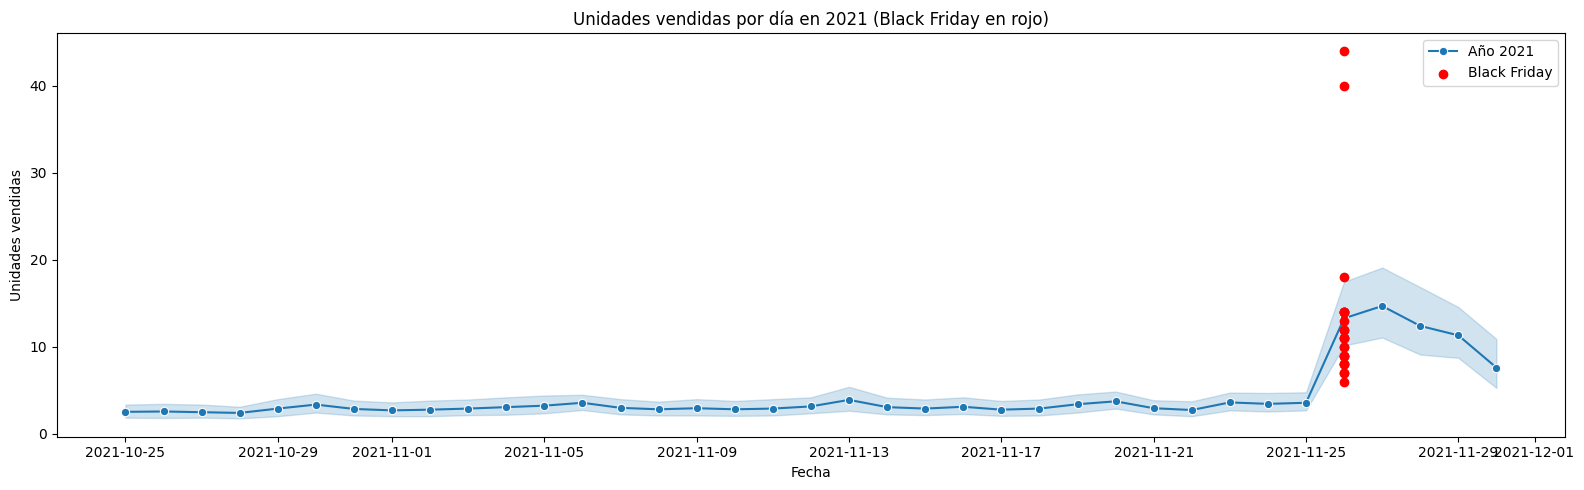

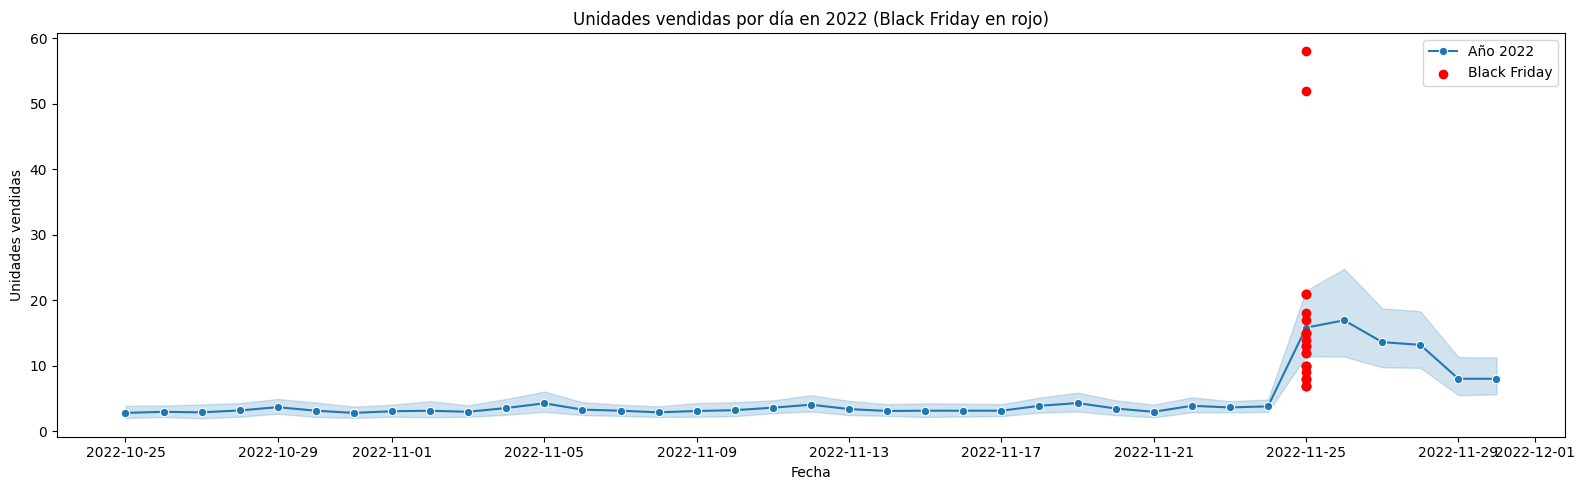

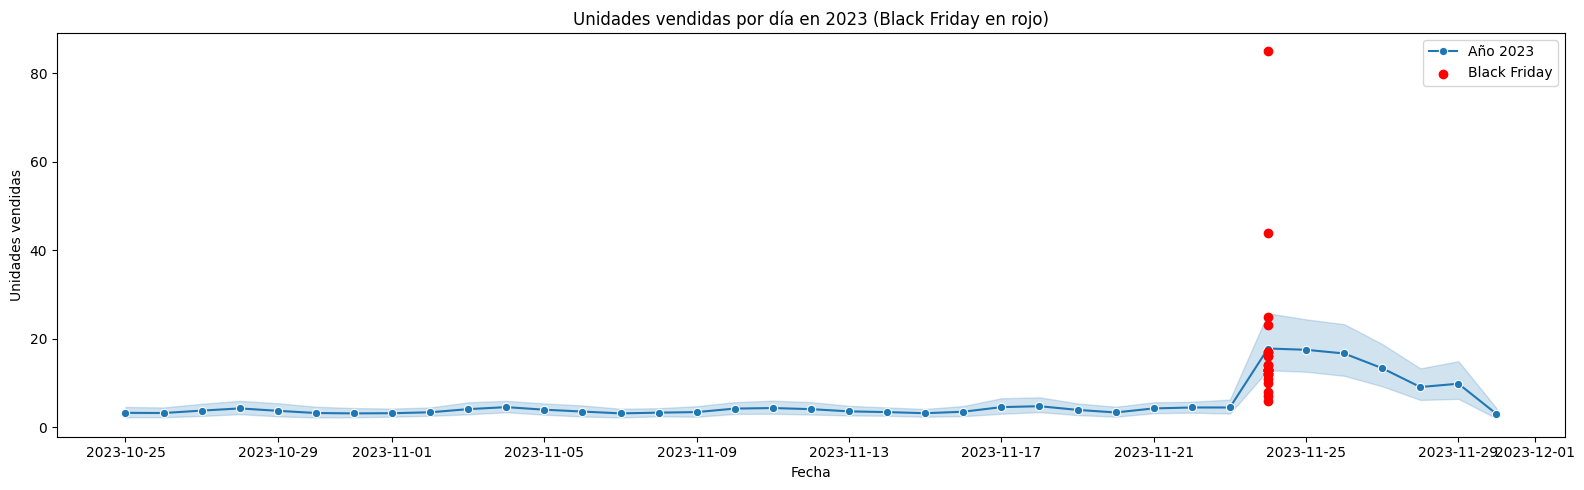

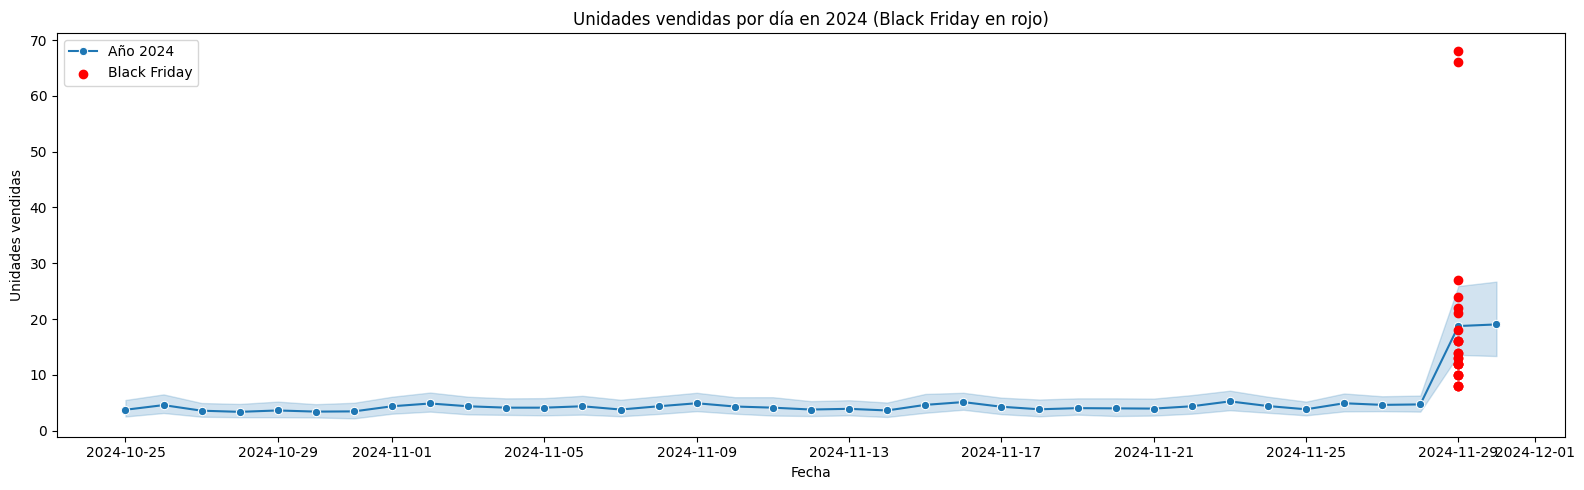

In [93]:
# Aseguramos que la columna 'fecha' es datetime
if not np.issubdtype(df['fecha'].dtype, np.datetime64):
    df['fecha'] = pd.to_datetime(df['fecha'])

# Obtenemos los años únicos
años = df['año'].unique()

# Creamos un gráfico para cada año
for año in sorted(años):
    plt.figure(figsize=(16, 5))
    datos_año = df[df['año'] == año]
    sns.lineplot(data=datos_año, x='fecha', y='unidades_vendidas', marker='o', label=f'Año {año}')
    # Marcamos los días de Black Friday
    black_fridays = datos_año[datos_año['es_black_friday']]
    plt.scatter(black_fridays['fecha'], black_fridays['unidades_vendidas'], color='red', label='Black Friday', zorder=5)
    plt.title(f'Unidades vendidas por día en {año} (Black Friday en rojo)')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Unidades vendidas por día de la semana

A continuación se muestra un gráfico de la suma de unidades vendidas agrupadas por cada día de la semana.

C:\Users\pablo\AppData\Local\Temp\ipykernel_19440\3301993459.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_dia.index, y=df_dia.values, palette='viridis')


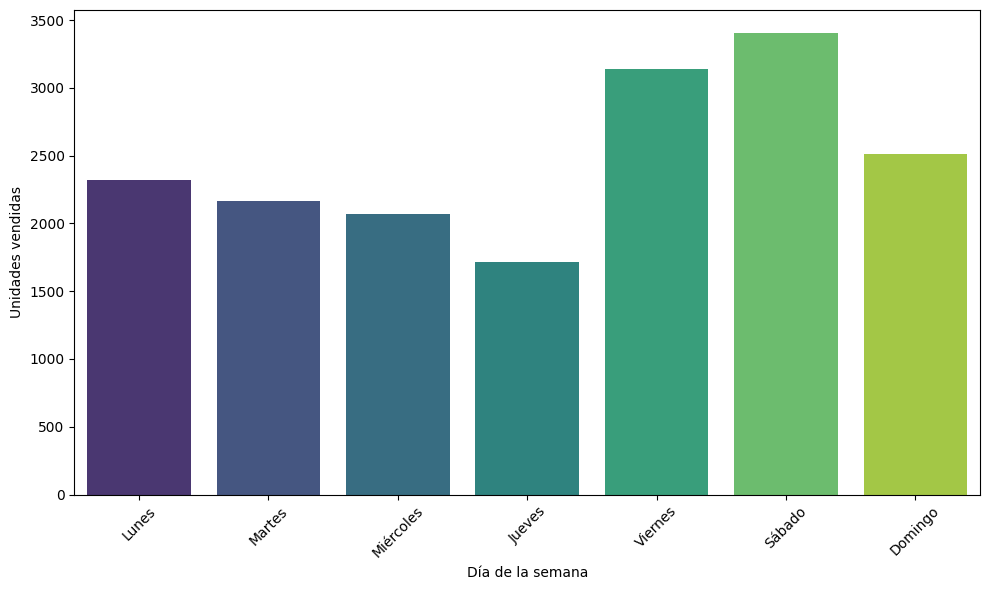

In [94]:
plt.figure(figsize=(10,6))
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_dia = df.groupby('nombre_dia')['unidades_vendidas'].sum().reindex(orden_dias)
sns.barplot(x=df_dia.index, y=df_dia.values, palette='viridis')
plt.ylabel('Unidades vendidas')
plt.xlabel('Día de la semana')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Unidades vendidas por categoría

A continuación se muestra un gráfico de la suma de unidades vendidas agrupadas por cada categoría de producto.

C:\Users\pablo\AppData\Local\Temp\ipykernel_19440\4294671820.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suma_categoria.index, y=suma_categoria.values, palette='crest')


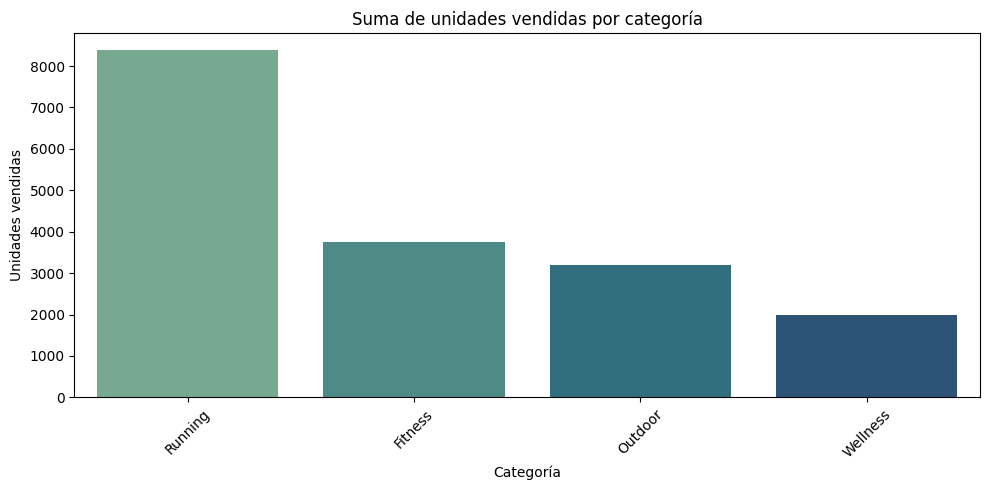

In [95]:
plt.figure(figsize=(10,5))
suma_categoria = df.groupby('categoria')['unidades_vendidas'].sum().sort_values(ascending=False)
sns.barplot(x=suma_categoria.index, y=suma_categoria.values, palette='crest')
plt.xlabel('Categoría')
plt.ylabel('Unidades vendidas')
plt.title('Suma de unidades vendidas por categoría')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Unidades vendidas por subcategoría

A continuación se muestra un gráfico de la suma de unidades vendidas agrupadas por cada subcategoría de producto.

C:\Users\pablo\AppData\Local\Temp\ipykernel_19440\1486688111.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suma_subcat.index, y=suma_subcat.values, palette='mako')


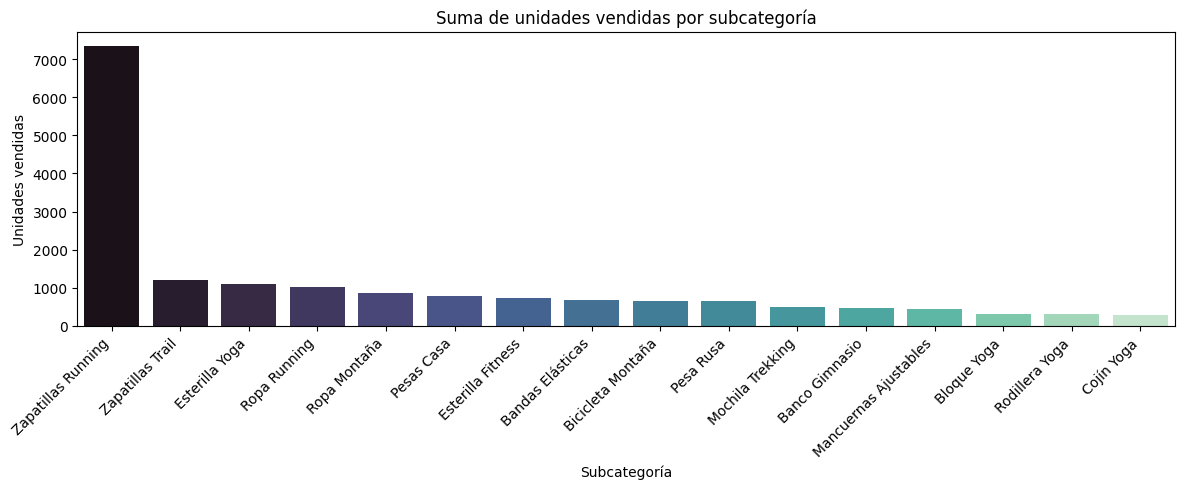

In [96]:
plt.figure(figsize=(12,5))
suma_subcat = df.groupby('subcategoria')['unidades_vendidas'].sum().sort_values(ascending=False)
sns.barplot(x=suma_subcat.index, y=suma_subcat.values, palette='mako')
plt.xlabel('Subcategoría')
plt.ylabel('Unidades vendidas')
plt.title('Suma de unidades vendidas por subcategoría')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top productos por unidades vendidas

A continuación se muestra un gráfico de los productos con mayor número de unidades vendidas (top 10).

C:\Users\pablo\AppData\Local\Temp\ipykernel_19440\769614559.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_productos.index, y=top_productos.values, palette='rocket')


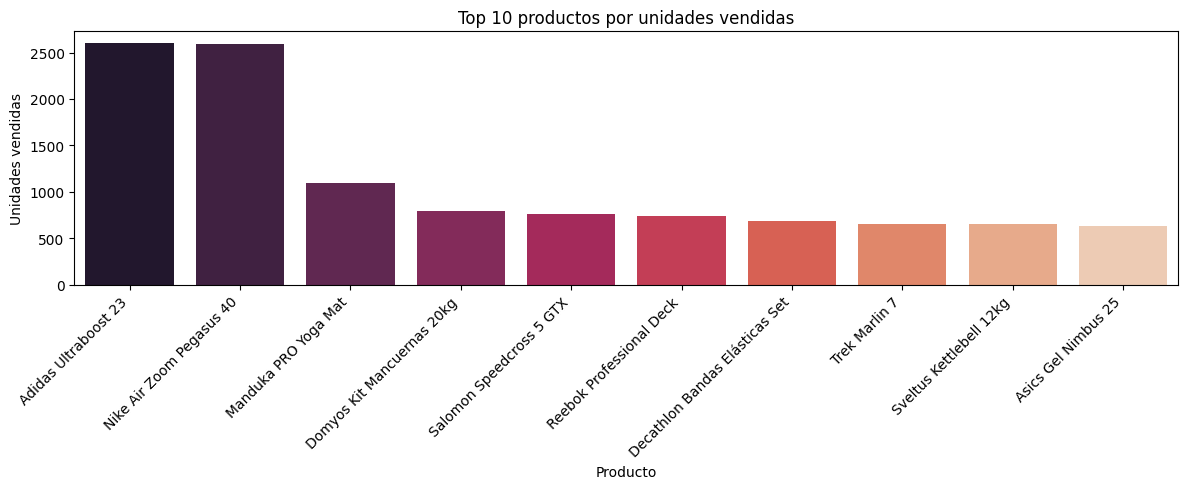

In [97]:
plt.figure(figsize=(12,5))
top_productos = df.groupby('nombre')['unidades_vendidas'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_productos.index, y=top_productos.values, palette='rocket')
plt.xlabel('Producto')
plt.ylabel('Unidades vendidas')
plt.title('Top 10 productos por unidades vendidas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis de densidad de precios: nuestros precios vs Amazon

A continuación se muestra un gráfico de densidad (KDE) comparando la distribución de nuestros precios de venta frente a los precios de Amazon para los mismos productos.

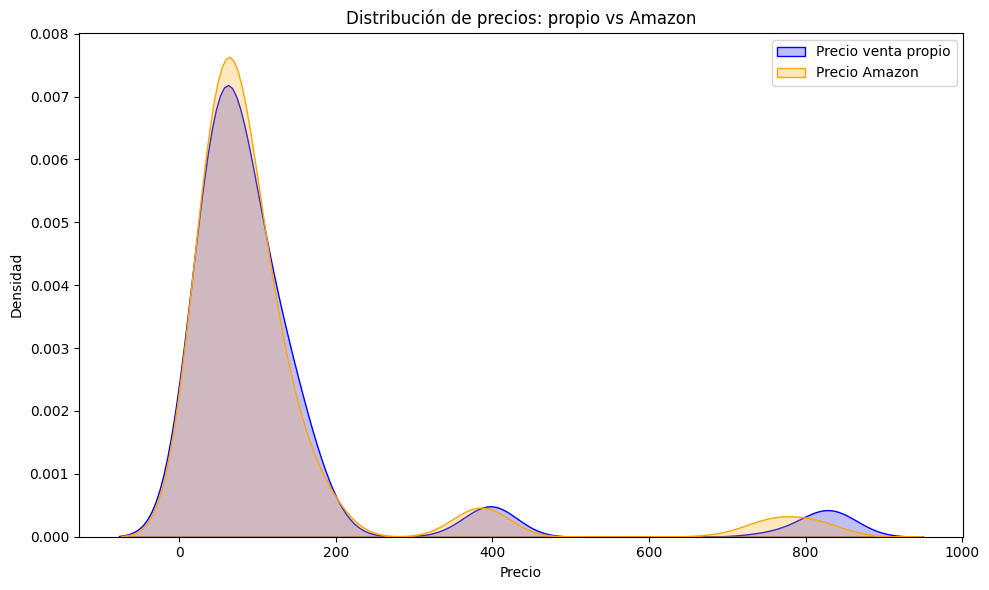

In [98]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['precio_venta'], label='Precio venta propio', fill=True, color='blue')
if 'Amazon' in df.columns:
    sns.kdeplot(df['Amazon'], label='Precio Amazon', fill=True, color='orange')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.title('Distribución de precios: propio vs Amazon')
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
## PREPARACION PARA EL MODELO (CREACIÓN DE VARIABLES)  ##

In [100]:
# Crear lags de unidades vendidas y media móvil de 7 días por producto y año
for producto in df['producto_id'].unique():
    for anio in df[df['producto_id'] == producto]['año'].unique():
        mask = (df['producto_id'] == producto) & (df['año'] == anio)
        df.loc[mask, 'lag1'] = df.loc[mask, 'unidades_vendidas'].shift(1)
        df.loc[mask, 'lag2'] = df.loc[mask, 'unidades_vendidas'].shift(2)
        df.loc[mask, 'lag3'] = df.loc[mask, 'unidades_vendidas'].shift(3)
        df.loc[mask, 'lag4'] = df.loc[mask, 'unidades_vendidas'].shift(4)
        df.loc[mask, 'lag5'] = df.loc[mask, 'unidades_vendidas'].shift(5)
        df.loc[mask, 'lag6'] = df.loc[mask, 'unidades_vendidas'].shift(6)
        df.loc[mask, 'lag7'] = df.loc[mask, 'unidades_vendidas'].shift(7)
        df.loc[mask, 'media_movil_7d'] = df.loc[mask, 'unidades_vendidas'].rolling(window=7, min_periods=1).mean()

# Eliminar registros con nulos en los nuevos lags o media móvil
df = df.dropna(subset=['lag1','lag2','lag3','lag4','lag5','lag6','lag7','media_movil_7d']).reset_index(drop=True)

# Visualización de los primeros registros con lags y media móvil
df[['fecha','producto_id','año','unidades_vendidas','lag1','lag2','lag3','lag4','lag5','lag6','lag7','media_movil_7d']].head(10)

,fecha,producto_id,año,unidades_vendidas,lag1,lag2,lag3,lag4,lag5,lag6,lag7,media_movil_7d
0,2021-11-01,PROD_001,2021,7,9.0,12.0,12.0,7.0,8.0,8.0,6.0,9.000000
1,2021-11-01,PROD_002,2021,10,10.0,12.0,9.0,8.0,8.0,10.0,10.0,9.571429
2,2021-11-01,PROD_003,2021,2,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.571429
3,2021-11-01,PROD_004,2021,2,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.285714
4,2021-11-01,PROD_005,2021,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000
5,2021-11-01,PROD_006,2021,2,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.142857
6,2021-11-01,PROD_007,2021,2,2.0,3.0,2.0,1.0,2.0,2.0,2.0,2.000000
7,2021-11-01,PROD_008,2021,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000
8,2021-11-01,PROD_009,2021,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.857143
9,2021-11-01,PROD_010,2021,2,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.571429


In [101]:
# Crear variable de descuento en porcentaje
df['descuento'] = ((df['precio_venta'] - df['precio_base']) / df['precio_base']) * 100

# Visualización de la variable descuento
df[['fecha','producto_id','precio_base','precio_venta','descuento']].head(10)

,fecha,producto_id,precio_base,precio_venta,descuento
0,2021-11-01,PROD_001,115,115.07,0.060870
1,2021-11-01,PROD_002,135,136.00,0.740741
2,2021-11-01,PROD_003,85,85.14,0.164706
3,2021-11-01,PROD_004,75,76.74,2.320000
4,2021-11-01,PROD_005,35,34.89,-0.314286
5,2021-11-01,PROD_006,65,64.67,-0.507692
6,2021-11-01,PROD_007,70,71.38,1.971429
7,2021-11-01,PROD_008,65,63.09,-2.938462
8,2021-11-01,PROD_009,400,397.99,-0.502500
9,2021-11-01,PROD_010,175,172.48,-1.440000


In [102]:
# Calcular el precio promedio de la competencia
df['precio_competencia'] = df[['Amazon', 'Decathlon', 'Deporvillage']].mean(axis=1)

# Calcular el ratio de nuestro precio respecto a la competencia
df['ratio_precio'] = df['precio_venta'] / df['precio_competencia']

# Eliminar las columnas de los competidores
df = df.drop(columns=['Amazon', 'Decathlon', 'Deporvillage'])

# Visualización de las nuevas variables
df[['fecha','producto_id','precio_venta','precio_competencia','ratio_precio']].head(10)

,fecha,producto_id,precio_venta,precio_competencia,ratio_precio
0,2021-11-01,PROD_001,115.07,95.353333,1.206775
1,2021-11-01,PROD_002,136.00,113.393333,1.199365
2,2021-11-01,PROD_003,85.14,83.276667,1.022375
3,2021-11-01,PROD_004,76.74,71.843333,1.068158
4,2021-11-01,PROD_005,34.89,33.490000,1.041804
5,2021-11-01,PROD_006,64.67,63.533333,1.017891
6,2021-11-01,PROD_007,71.38,66.003333,1.081461
7,2021-11-01,PROD_008,63.09,62.160000,1.014961
8,2021-11-01,PROD_009,397.99,350.043333,1.136974
9,2021-11-01,PROD_010,172.48,159.886667,1.078764


In [103]:
# Crear copias de las variables categóricas con sufijo _h
df['nombre_h'] = df['nombre']
df['categoria_h'] = df['categoria']
df['subcategoria_h'] = df['subcategoria']

# OneHotEncoding sobre las nuevas variables
df = pd.get_dummies(df, columns=['nombre_h', 'categoria_h', 'subcategoria_h'], drop_first=True)

# Visualización de las primeras columnas tras el OneHotEncoding
df.filter(regex='nombre_h|categoria_h|subcategoria_h').head()

,nombre_h_Adidas Ultraboost 23,nombre_h_Asics Gel Nimbus 25,nombre_h_Bowflex SelectTech 552,nombre_h_Columbia Silver Ridge,nombre_h_Decathlon Bandas Elásticas Set,nombre_h_Domyos BM900,nombre_h_Domyos Kit Mancuernas 20kg,nombre_h_Gaiam Premium Yoga Block,nombre_h_Liforme Yoga Pad,nombre_h_Lotuscrafts Yoga Bolster,...,subcategoria_h_Esterilla Yoga,subcategoria_h_Mancuernas Ajustables,subcategoria_h_Mochila Trekking,subcategoria_h_Pesa Rusa,subcategoria_h_Pesas Casa,subcategoria_h_Rodillera Yoga,subcategoria_h_Ropa Montaña,subcategoria_h_Ropa Running,subcategoria_h_Zapatillas Running,subcategoria_h_Zapatillas Trail
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [104]:
df.to_csv(r"D:\forecasting_retailer\data\processed\df.csv")

In [105]:
# Dividir el dataframe en train y validation según el año
train_df = df[df['año'].isin([2021, 2022, 2023])].copy()
validation_df = df[df['año'] == 2024].copy()

print(f"Registros en train_df: {len(train_df)}")
print(f"Registros en validation_df: {len(validation_df)}")

Registros en train_df: 2160
Registros en validation_df: 720


In [106]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Selecciona columnas específicas excluyendo las no deseadas."""
    def __init__(self, exclude_cols=None, exclude_dtypes=None):
        self.exclude_cols = exclude_cols or []
        self.exclude_dtypes = exclude_dtypes or []

    def fit(self, X, y=None):
        self.feature_names_ = [
            col for col in X.columns 
            if col not in self.exclude_cols 
            and X[col].dtype not in self.exclude_dtypes
        ]
        return self

    def transform(self, X):
        return X[self.feature_names_]

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_)

In [107]:
# Configuración del Pipeline
pipeline = Pipeline([
    ('selector', ColumnSelector(
        exclude_cols=['fecha', 'ingresos', 'unidades_vendidas'],
        exclude_dtypes=['O']  # Excluye tipo object
    )),
    ('scaler', StandardScaler()),  # Opcional: normalización
    ('model', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=400,
        max_depth=7,
        l2_regularization=1.0,
        early_stopping=True,
        random_state=42
    ))
])

# Entrenamiento
pipeline.fit(train_df, train_df['unidades_vendidas'])

# Predicciones
y_pred = pipeline.predict(validation_df)

# Baseline naive (referencia)
y_pred_naive = np.full(len(validation_df), train_df['unidades_vendidas'].mean())


print("=== Evaluación del Modelo ===")
print(f"MAE Pipeline: {mean_absolute_error(validation_df['unidades_vendidas'], y_pred):.2f}")
print(f"RMSE Pipeline: {np.sqrt(mean_squared_error(validation_df['unidades_vendidas'], y_pred)):.2f}")
print(f"R² Pipeline: {r2_score(validation_df['unidades_vendidas'], y_pred):.3f}")
print(f"\nMAE Baseline: {mean_absolute_error(validation_df['unidades_vendidas'], y_pred_naive):.2f}")

# Opcional: Ver las features seleccionadas
print(f"\n=== Features Utilizadas ({len(pipeline.named_steps['selector'].feature_names_)}) ===")
print(pipeline.named_steps['selector'].feature_names_)

=== Evaluación del Modelo ===
MAE Pipeline: 0.78
RMSE Pipeline: 1.75
R² Pipeline: 0.932

MAE Baseline: 3.67

=== Features Utilizadas (68) ===
['precio_base', 'es_estrella', 'precio_venta', 'año', 'mes', 'dia_mes', 'dia_semana', 'es_fin_semana', 'es_festivo', 'es_black_friday', 'es_cyber_monday', 'semana_año', 'trimestre', 'dia_año', 'es_inicio_mes', 'es_fin_mes', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'media_movil_7d', 'descuento', 'precio_competencia', 'ratio_precio', 'nombre_h_Adidas Ultraboost 23', 'nombre_h_Asics Gel Nimbus 25', 'nombre_h_Bowflex SelectTech 552', 'nombre_h_Columbia Silver Ridge', 'nombre_h_Decathlon Bandas Elásticas Set', 'nombre_h_Domyos BM900', 'nombre_h_Domyos Kit Mancuernas 20kg', 'nombre_h_Gaiam Premium Yoga Block', 'nombre_h_Liforme Yoga Pad', 'nombre_h_Lotuscrafts Yoga Bolster', 'nombre_h_Manduka PRO Yoga Mat', 'nombre_h_Merrell Moab 2 GTX', 'nombre_h_New Balance Fresh Foam X 1080v12', 'nombre_h_Nike Air Zoom Pegasus 40', 'nombre_h_Nike Dri-

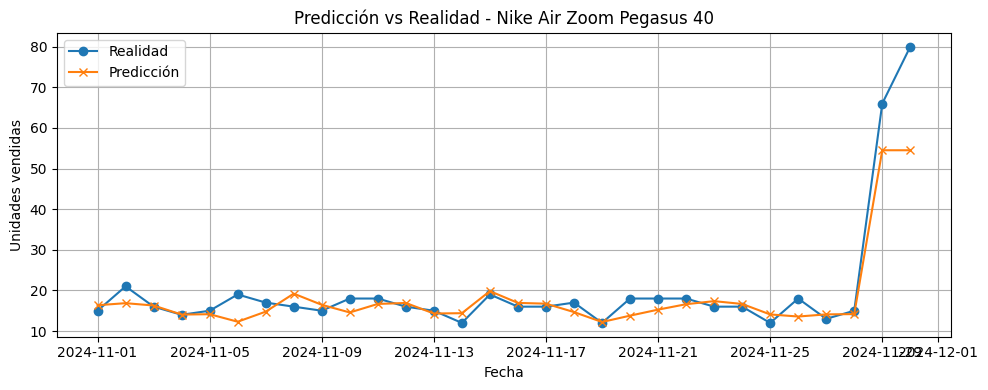

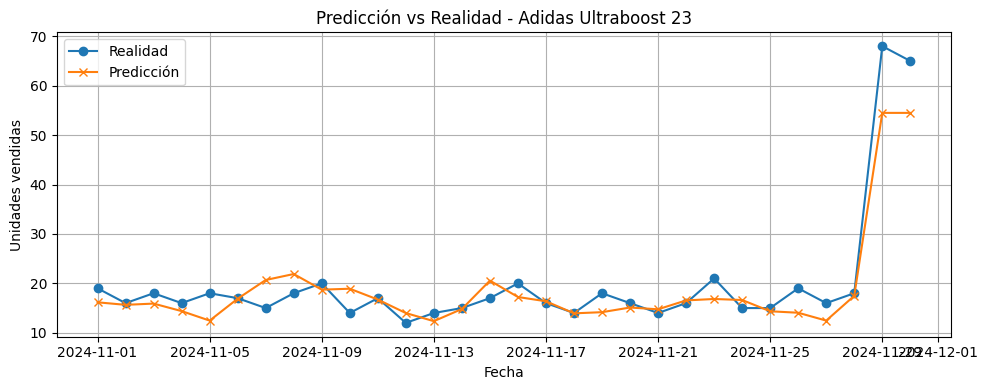

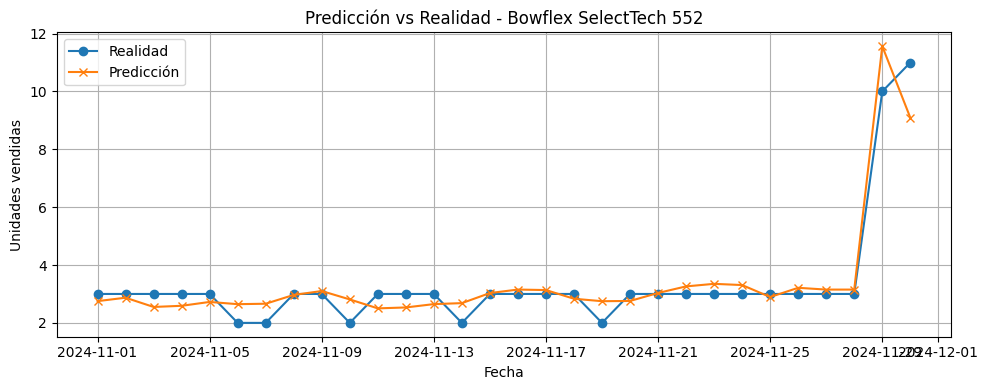

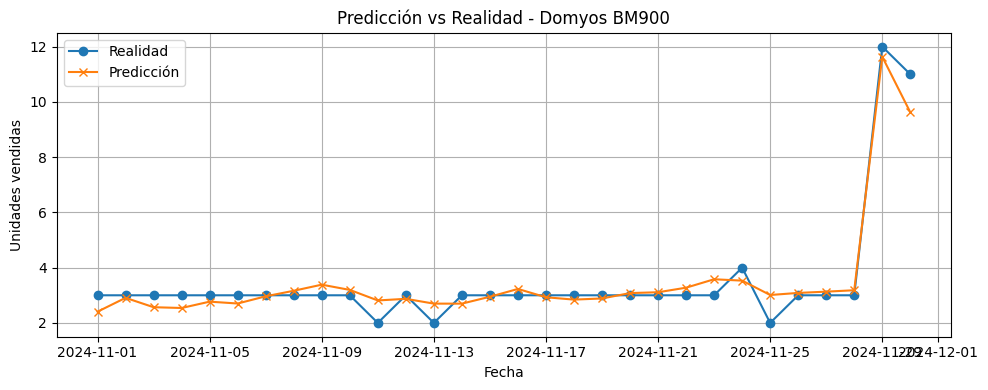

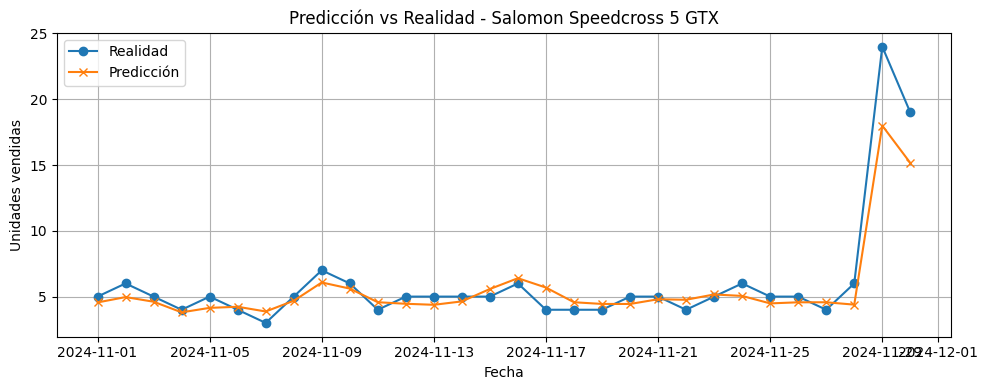

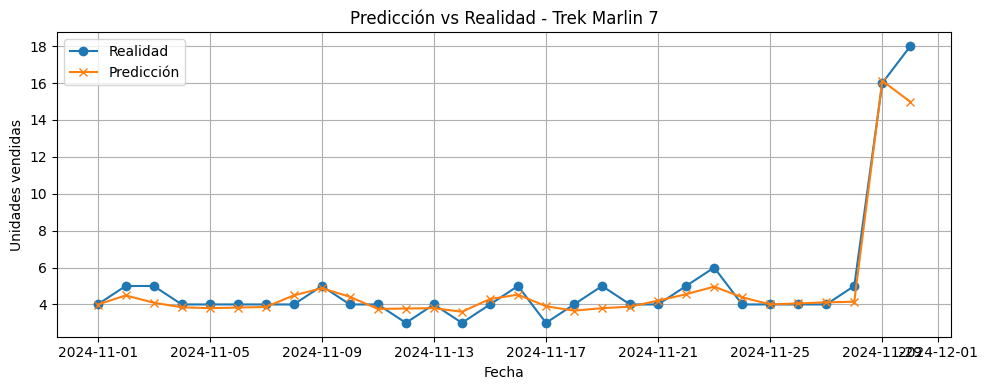

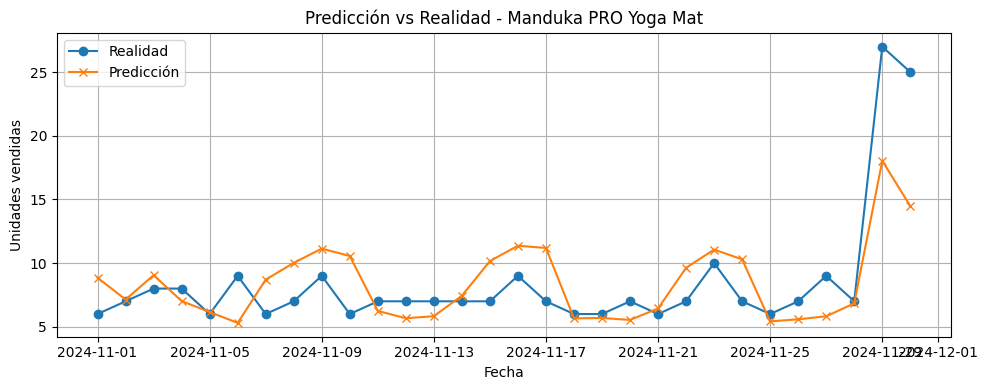

In [108]:
# Filtrar datos de noviembre 2024 y productos estrella
df_nov2024 = df[(df['año'] == 2024) & (df['mes'] == 11) & (df['es_estrella'] == 1)].copy()
productos_estrella = df_nov2024['producto_id'].unique()

# Usar las mismas columnas predictoras que en el entrenamiento
X_cols = [col for col in df_nov2024.columns if col not in ['fecha', 'ingresos', 'unidades_vendidas'] and df_nov2024[col].dtype != 'O']

for producto in productos_estrella:
    datos_prod = df_nov2024[df_nov2024['producto_id'] == producto].copy()
    if datos_prod.empty:
        continue
    X_prod = datos_prod[X_cols]
    y_real = datos_prod['unidades_vendidas']
    fechas = datos_prod['fecha']
    y_pred = pipeline.predict(X_prod)
    nombre = datos_prod['nombre'].iloc[0] if 'nombre' in datos_prod.columns else str(producto)
    plt.figure(figsize=(10,4))
    plt.plot(fechas, y_real, marker='o', label='Realidad')
    plt.plot(fechas, y_pred, marker='x', label='Predicción')
    plt.title(f'Predicción vs Realidad - {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [109]:
# Calcular el MAE para cada producto estrella en noviembre 2024
mae_por_producto = {}
for producto in productos_estrella:
    datos_prod = df_nov2024[df_nov2024['producto_id'] == producto].copy()
    if datos_prod.empty:
        continue
    X_prod = datos_prod[X_cols]
    y_real = datos_prod['unidades_vendidas']
    y_pred = pipeline.predict(X_prod)
    nombre = datos_prod['nombre'].iloc[0] if 'nombre' in datos_prod.columns else str(producto)
    mae = mean_absolute_error(y_real, y_pred)
    mae_por_producto[nombre] = mae

print('MAE por producto estrella en noviembre 2024:')
for nombre, mae in mae_por_producto.items():
    print(f'{nombre}: {mae:.2f}')

MAE por producto estrella en noviembre 2024:
Nike Air Zoom Pegasus 40: 3.00
Adidas Ultraboost 23: 2.82
Bowflex SelectTech 552: 0.41
Domyos BM900: 0.34
Salomon Speedcross 5 GTX: 0.90
Trek Marlin 7: 0.48
Manduka PRO Yoga Mat: 2.30


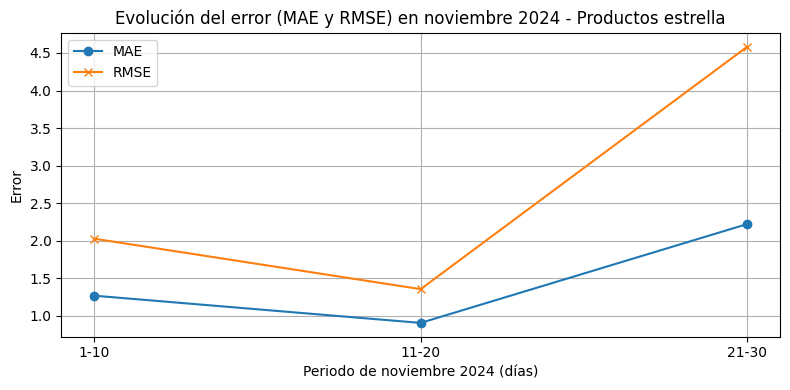

Periodo 1 (días 1-10): MAE=1.27, RMSE=2.03
Periodo 2 (días 11-20): MAE=0.90, RMSE=1.35
Periodo 3 (días 21-30): MAE=2.22, RMSE=4.58


In [110]:
# Añadir columna de periodo a df_nov2024
periodos = [(1,10), (11,20), (21,30)]
def asignar_periodo(dia):
    for i, (ini, fin) in enumerate(periodos, 1):
        if ini <= dia <= fin:
            return i
    return np.nan
df_nov2024['periodo'] = df_nov2024['dia_mes'].apply(asignar_periodo)

# Calcular métricas por periodo (MAE y RMSE, todos los productos estrella juntos)
mae_periodo = []
rmse_periodo = []
for p in range(1, 4):
    datos_p = df_nov2024[df_nov2024['periodo'] == p]
    if datos_p.empty:
        mae_periodo.append(np.nan)
        rmse_periodo.append(np.nan)
        continue
    X_p = datos_p[X_cols]
    y_real_p = datos_p['unidades_vendidas']
    y_pred_p = pipeline.predict(X_p)
    mae_periodo.append(mean_absolute_error(y_real_p, y_pred_p))
    rmse_periodo.append(np.sqrt(mean_squared_error(y_real_p, y_pred_p)))

# Gráfico de la evolución del error
plt.figure(figsize=(8,4))
plt.plot([1,2,3], mae_periodo, marker='o', label='MAE')
plt.plot([1,2,3], rmse_periodo, marker='x', label='RMSE')
plt.xticks([1,2,3], ['1-10', '11-20', '21-30'])
plt.xlabel('Periodo de noviembre 2024 (días)')
plt.ylabel('Error')
plt.title('Evolución del error (MAE y RMSE) en noviembre 2024 - Productos estrella')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar métricas por periodo
for i, (mae, rmse) in enumerate(zip(mae_periodo, rmse_periodo), 1):
    print(f'Periodo {i} (días {periodos[i-1][0]}-{periodos[i-1][1]}): MAE={mae:.2f}, RMSE={rmse:.2f}')

In [111]:
# Modelo Final #

pipeline_final = Pipeline([
    ('selector', ColumnSelector(
        exclude_cols=['fecha', 'ingresos', 'unidades_vendidas', 
                      'nombre', 'producto_id', 'categoria', 'subcategoria'],
        exclude_dtypes=['O']
    )),
    ('scaler', StandardScaler()),
    ('model', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=400,
        max_depth=7,
        l2_regularization=1.0,
        early_stopping=True,
        random_state=42
    ))
])

pipeline_final.fit(df, df['unidades_vendidas'])
print('✓ Modelo final entrenado con todos los datos históricos (2021-2024).')
print(f'✓ Features utilizadas: {len(pipeline_final.named_steps["selector"].feature_names_)}')
print(f'✓ Columnas: {pipeline_final.named_steps["selector"].feature_names_}')

✓ Modelo final entrenado con todos los datos históricos (2021-2024).
✓ Features utilizadas: 68
✓ Columnas: ['precio_base', 'es_estrella', 'precio_venta', 'año', 'mes', 'dia_mes', 'dia_semana', 'es_fin_semana', 'es_festivo', 'es_black_friday', 'es_cyber_monday', 'semana_año', 'trimestre', 'dia_año', 'es_inicio_mes', 'es_fin_mes', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'media_movil_7d', 'descuento', 'precio_competencia', 'ratio_precio', 'nombre_h_Adidas Ultraboost 23', 'nombre_h_Asics Gel Nimbus 25', 'nombre_h_Bowflex SelectTech 552', 'nombre_h_Columbia Silver Ridge', 'nombre_h_Decathlon Bandas Elásticas Set', 'nombre_h_Domyos BM900', 'nombre_h_Domyos Kit Mancuernas 20kg', 'nombre_h_Gaiam Premium Yoga Block', 'nombre_h_Liforme Yoga Pad', 'nombre_h_Lotuscrafts Yoga Bolster', 'nombre_h_Manduka PRO Yoga Mat', 'nombre_h_Merrell Moab 2 GTX', 'nombre_h_New Balance Fresh Foam X 1080v12', 'nombre_h_Nike Air Zoom Pegasus 40', 'nombre_h_Nike Dri-FIT Miler', 'nombre_h_Puma Velocity

In [112]:
# Guardar el modelo final
joblib.dump(pipeline_final, r"D:\forecasting_retailer\model\modelo_final.joblib")

['D:\\forecasting_retailer\\model\\modelo_final.joblib']